In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = "DW_2000Q_2_1"
api_key = 'DEV-3142f58be13a0aacd44657b15b8fb9832ba3bdac'

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [17]:
# Import data

dataset = 'ftse' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('../Data/%s/%s_corr.npy' % (dataset, dataset))
dates = np.load('../Data/%s/%s_dates.npy' % (dataset, dataset))
nodes = np.load('../Data/%s/%s_nodes.npy' % (dataset, dataset))
nodes_descr = np.load('../Data/%s/%s_nodes_descr.npy' % (dataset, dataset))

num_examples = corr_tensor.shape[0]
dim = corr_tensor.shape[1]

In [18]:
print("num examples: %d, matrix dim: %d" % (num_examples, dim))

num examples: 120, matrix dim: 21


In [19]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def coloring_score(G, coloring):
    count = 0
    for e in G.edges():
        v1, v2 = e
        if coloring[v1] == coloring[v2]:
            count += 1
        
        return count/G.number_of_edges()

In [20]:
# Test to see if DW comp. is working
corr_mat = corr_tensor[int(num_examples/2), :, :]
        
corr_mat[(corr_mat > -1*0.1) & (corr_mat < 0.1)] = 0
G, density = make_graph(corr_mat, nodes, 'corr')

coloring = dnx.min_vertex_coloring(G, sampler)
num_colors = np.max(list(coloring.values()))

In [6]:
assert num_colors > 0 and num_colors < get_max_deg(G)

In [7]:
dnx.is_vertex_coloring(G, coloring)

True

In [8]:
coloring_score(G, coloring)

0.0

In [9]:
# Plot graph density for each threshold. 
thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/5)):
        corr_mat = corr_tensor[j*5, :, :]
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        density_array.append(density)
    
    density_distr.append(density_array)

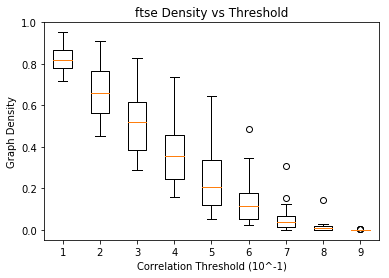

In [10]:
plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("%s Density vs Threshold" % (dataset))
plt.show()

In [24]:
# Create graph for each month and calculate best coloring. 

coloring_array = []
valid_coloring_array = []
num_colors_array = []
date_array = []
density_array = []
threshold_array = []

count = 0
for i in np.arange(0.4, 0.8, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :]
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        count += 1
        if count % 10 == 0: print("count: %d" % (count))
        
        try:
            coloring = dnx.min_vertex_coloring(G, sampler)
            num_colors = np.max(list(coloring.values()))
            valid_coloring = dnx.is_vertex_coloring(G, coloring)
        except Exception as e:
            print(e)
            print("No embedding found for threshold %f and matrix %d" % (i, j*5))
        else:
            num_colors_array.append(num_colors)
            coloring_array.append(coloring)
            valid_coloring_array.append(valid_coloring)

            threshold_array.append(i)
            density_array.append(density)
            date_array.append(dates[j*5])

No embedding found for threshold 0.400000 and matrix 5
No embedding found for threshold 0.400000 and matrix 20
No embedding found for threshold 0.400000 and matrix 25


KeyError: 'WPP'

In [92]:
assert len(coloring_array) == len(date_array) == len(density_array) == len(threshold_array) == len(num_colors_array)

In [30]:
len(coloring_array)

0

In [94]:
# Create Pandas DataFrame for results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array}).to_csv("grphcolor_%s_res.csv" % (dataset))